# Trial 2 Undergraduate Thesis
Goal :
- Create XGBoost and Linear Regresion Model
- Get insights from the datas
- Get the best blanket configuration

Name : Husni Naufal Zuhdi (413821)

## Regression exercise with XGBoost

In [3]:
# Basic Numerical Packages
import numpy as np
import pandas as pd
import csv as csv
import os

# Ploting Packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

# XGBoost and Machine Learning related Packages
import xgboost as xgb
from xgboost import plot_importance
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import skew
from collections import OrderedDict

In [4]:
# Set Cloud Storage Service Account
from google.cloud import storage
client = storage.Client.from_service_account_json(
    'key.json', project='iter-tritium-breeding-xgboost'
)

In [7]:
# Set variables of result file
enrich_lis = [0.1, 0.3, 0.5, 0.7, 0.9]
mod_ratios = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
neutron_multis = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
bucket = client.bucket("iter-tritium-breeding-xgboost-bucket") # Your bucket name
result_uri = "v2/results/" # Result.json files uri

# Download all result.json file in Cloud Storage Bucket
for enrich_li in enrich_lis:
    for mod_ratio in mod_ratios:
        for neutron_multi in neutron_multis:
            try:
                print("Downloading : " + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
                blob = bucket.blob(result_uri + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
                blob.download_to_filename("result/" + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
            except Exception:
                pass

In [8]:
# Read folder contain simulation results
path = "/home/husninaufalz/iter-tritium-breeding-xgboost/jupyter-notebooks/2-data-analysis/result"
results = os.listdir(path=path)
results.sort()

In [9]:
# Read data in each folder
data = []
for result in results:
    # Find enrichment feature
    folder_path = path + str(result)
    folder_list = result.split('-')
    folder_list = folder_list[0:3]
    
    # Read tbr and std dev data
    try:
        json_result = pd.read_json(path + "/" + result)
        json_result = json_result["blanket_fluid_mat_(n,Xt)"]["events per source particle"]
        data.append([folder_list[0], folder_list[1], folder_list[2], json_result['result'], json_result['std. dev.']])
    except Exception:
        pass

# Build dataframe from simulation data
df = pd.DataFrame(data, columns=['Li6_enrichment', 'Moderator_ratio','Neutron_multiplier', 'Tbr_OpenMC', 'Stddev'])

# Convert all dataframe type from string into float
df.Li6_enrichment = df.Li6_enrichment.astype(float)
df.Moderator_ratio = df.Moderator_ratio.astype(float)
df.Neutron_multiplier = df.Neutron_multiplier.astype(float)

[Text(0.5, 0, 'Neutron Multiplier (%)')]

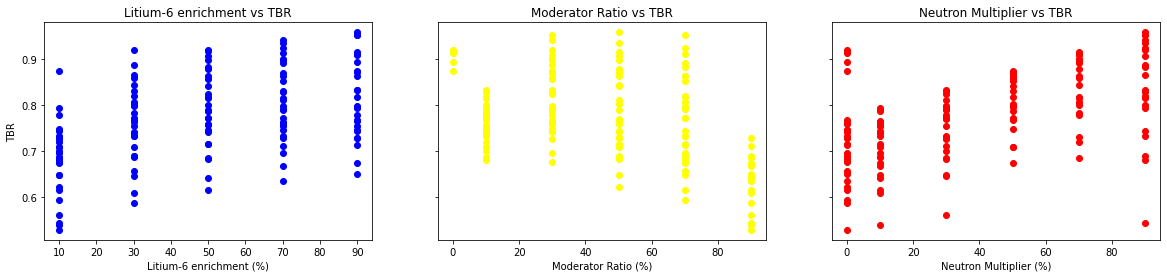

In [10]:
# Plot each features vs TBR
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 4))
ax1.scatter(df.Li6_enrichment*100, df.Tbr_OpenMC, c = "blue", marker = "o")
ax1.set_title("Litium-6 enrichment vs TBR")
ax1.set(xlabel='Litium-6 enrichment (%)', ylabel='TBR')
ax2.scatter(df.Moderator_ratio*100, df.Tbr_OpenMC, c = "yellow", marker = "o")
ax2.set_title("Moderator Ratio vs TBR")
ax2.set(xlabel='Moderator Ratio (%)')
ax3.scatter(df.Neutron_multiplier*100, df.Tbr_OpenMC, c = "red", marker = "o")
ax3.set_title("Neutron Multiplier vs TBR")
ax3.set(xlabel='Neutron Multiplier (%)')

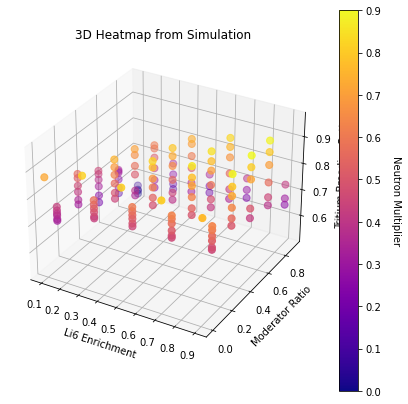

In [11]:
# Read the dataset
x = df["Li6_enrichment"].tolist()
y = df["Moderator_ratio"].tolist()
z = df["Tbr_OpenMC"].tolist()

colo = df["Neutron_multiplier"].tolist()

# Creating 3d figures
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.plasma)
color_map.set_array(colo)

# Creating the heatmap
img = ax.scatter(x, y, z, marker='o', s=50, c=z, cmap=cm.plasma)
heatmap = plt.colorbar(color_map)
heatmap.set_label('Neutron Multiplier', rotation=270, labelpad=20)

# Adding title and labels
ax.set_title("3D Heatmap from Simulation")
ax.set_xlabel('Li6 Enrichment')
ax.set_ylabel('Moderator Ratio')
ax.set_zlabel('Tritium Breeding Ratio')

# Displaying plot
plt.show()

In [12]:
# Split dataset into train and test datasets
features_columns = [col for col in df.columns if col not in ['Tbr_OpenMC', 'Stddev']]
X_train, X_test, y_train, y_test = train_test_split(df[features_columns],df['Tbr_OpenMC'],test_size=.3, random_state=42)

In [13]:
# Load data into DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [17]:
# First param
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
}

In [18]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:0.20516
[1]	Test-rmse:0.15425
[2]	Test-rmse:0.11472
[3]	Test-rmse:0.08696
[4]	Test-rmse:0.06907
[5]	Test-rmse:0.05477
[6]	Test-rmse:0.04451
[7]	Test-rmse:0.03611
[8]	Test-rmse:0.03042
[9]	Test-rmse:0.02682
[10]	Test-rmse:0.02440
[11]	Test-rmse:0.02250
[12]	Test-rmse:0.02130
[13]	Test-rmse:0.02025
[14]	Test-rmse:0.01953
[15]	Test-rmse:0.01898
[16]	Test-rmse:0.01871
[17]	Test-rmse:0.01838
[18]	Test-rmse:0.01814
[19]	Test-rmse:0.01794
[20]	Test-rmse:0.01778
[21]	Test-rmse:0.01762
[22]	Test-rmse:0.01756
[23]	Test-rmse:0.01752
[24]	Test-rmse:0.01749
[25]	Test-rmse:0.01741
[26]	Test-rmse:0.01738
[27]	Test-rmse:0.01737
[28]	Test-rmse:0.01737
[29]	Test-rmse:0.01737
[30]	Test-rmse:0.01737
[31]	Test-rmse:0.01737
[32]	Test-rmse:0.01737
[33]	Test-rmse:0.01737
[34]	Test-rmse:0.01737
[35]	Test-rmse:0.01737
[36]	Test-rmse:0.01737
[37]	Test-rmse:0.01737
[38]	Test-rmse:0.01737
[39]	Test-rmse:0.01737


In [19]:
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best RMSE: 0.02 with 31 rounds


In [20]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.209718,0.002409,0.209646,0.012087
1,0.153341,0.001753,0.154315,0.010830
2,0.113544,0.001295,0.117247,0.011235
3,0.084524,0.001213,0.091687,0.011171
4,0.063592,0.000986,0.073234,0.010849
5,0.048446,0.000719,0.060255,0.011465
6,0.037195,0.000415,0.049322,0.010424
7,0.028855,0.000369,0.041950,0.011792
8,0.022673,0.000350,0.036510,0.010899
9,0.018052,0.000415,0.032618,0.010151


In [26]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,5)
    for min_child_weight in range(1,5)
]

# Define initial best params and MAE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=1, min_child_weight=1
	RMSE 0.0291404 for 313 rounds
CV with max_depth=1, min_child_weight=2
	RMSE 0.0376982 for 139 rounds
CV with max_depth=1, min_child_weight=3
	RMSE 0.0415818 for 130 rounds
CV with max_depth=1, min_child_weight=4
	RMSE 0.0460024 for 94 rounds
CV with max_depth=2, min_child_weight=1
	RMSE 0.0172776 for 102 rounds
CV with max_depth=2, min_child_weight=2
	RMSE 0.024003200000000002 for 76 rounds
CV with max_depth=2, min_child_weight=3
	RMSE 0.027614 for 84 rounds
CV with max_depth=2, min_child_weight=4
	RMSE 0.0400556 for 19 rounds
CV with max_depth=3, min_child_weight=1
	RMSE 0.0171326 for 71 rounds
CV with max_depth=3, min_child_weight=2
	RMSE 0.023403200000000002 for 48 rounds
CV with max_depth=3, min_child_weight=3
	RMSE 0.026861200000000002 for 47 rounds
CV with max_depth=3, min_child_weight=4
	RMSE 0.038728599999999995 for 14 rounds
CV with max_depth=4, min_child_weight=1
	RMSE 0.018190400000000002 for 45 rounds
CV with max_depth=4, min_child_w

In [27]:
# Update first and second parameters
params['max_depth'] = 3
params['min_child_weight'] = 1

In [28]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 0.0171326 for 71 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 0.017664999999999997 for 92 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 0.017664999999999997 for 92 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 0.017664999999999997 for 92 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 0.0175216 for 109 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 0.0160982 for 120 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 0.0160982 for 120 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 0.0160982 for 120 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 0.0139748 for 190 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 0.0161014 for 85 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 0.0161014 for 85 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 0.0161014 for 85 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 0.016415199999999998 for 84 rounds
CV with subsample=0.7, colsample=0.9
	RMSE 0.0172504 for 87 rounds
CV with subsa

In [29]:
# Update third and fourth parameters
params['subsample'] = .8
params['colsample_bytree'] = 1.

In [43]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [.5, .35, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=999,seed=42,nfold=5,metrics=['rmse'],early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
CV with eta=0.5
CPU times: user 2min 48s, sys: 168 ms, total: 2min 48s
Wall time: 37.4 s
	RMSE 0.016275 for 62 rounds

CV with eta=0.35
CPU times: user 38.1 s, sys: 58 ms, total: 38.2 s
Wall time: 6.68 s
	RMSE 0.0136992 for 117 rounds

CV with eta=0.2
CPU times: user 3.17 s, sys: 20.7 ms, total: 3.19 s
Wall time: 787 ms
	RMSE 0.015057199999999998 for 195 rounds

CV with eta=0.1
CPU times: user 5.54 s, sys: 28.9 ms, total: 5.57 s
Wall time: 1.39 s
	RMSE 0.0140046 for 353 rounds

CV with eta=0.05
CPU times: user 9.12 s, sys: 53.4 ms, total: 9.17 s
Wall time: 2.3 s
	RMSE 0.014335800000000001 for 601 rounds

CV with eta=0.01
CPU times: user 14.9 s, sys: 49.3 ms, total: 15 s
Wall time: 3.75 s
	RMSE 0.0178852 for 998 rounds

CV with eta=0.005
CPU times: user 14.6 s, sys: 56.8 ms, total: 14.7 s
Wall time: 3.66 s
	RMSE 0.0253158 for 998 rounds

Best params: 0.35, RMSE: 0.0136992


In [44]:
# Update fifth parameters
params['eta'] = .35

In [47]:
new_model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-rmse:0.19362
[1]	Test-rmse:0.13985
[2]	Test-rmse:0.10273
[3]	Test-rmse:0.07546
[4]	Test-rmse:0.06214
[5]	Test-rmse:0.05025
[6]	Test-rmse:0.04248
[7]	Test-rmse:0.03760
[8]	Test-rmse:0.03426
[9]	Test-rmse:0.03108
[10]	Test-rmse:0.02874
[11]	Test-rmse:0.02735
[12]	Test-rmse:0.02583
[13]	Test-rmse:0.02383
[14]	Test-rmse:0.02287
[15]	Test-rmse:0.02205
[16]	Test-rmse:0.02138
[17]	Test-rmse:0.02085
[18]	Test-rmse:0.02056
[19]	Test-rmse:0.02051
[20]	Test-rmse:0.02059
[21]	Test-rmse:0.02007
[22]	Test-rmse:0.01946
[23]	Test-rmse:0.01957
[24]	Test-rmse:0.01880
[25]	Test-rmse:0.01879
[26]	Test-rmse:0.01818
[27]	Test-rmse:0.01814
[28]	Test-rmse:0.01828
[29]	Test-rmse:0.01823
[30]	Test-rmse:0.01788
[31]	Test-rmse:0.01748
[32]	Test-rmse:0.01731
[33]	Test-rmse:0.01700
[34]	Test-rmse:0.01674
[35]	Test-rmse:0.01644
[36]	Test-rmse:0.01624
[37]	Test-rmse:0.01576
[38]	Test-rmse:0.01551
[39]	Test-rmse:0.01538
[40]	Test-rmse:0.01527
[41]	Test-rmse:0.01511
[42]	Test-rmse:0.01499
[43]	Test-rmse:0.0151

In [23]:
# Build a validation dataframe
data_val = []
enrich = [0.05*x for x in range(1,20)]
nm = [0.05*x for x in range(1,20)]
mod = [0.03*x for x in range(1,10)]
for i in enrich:
    for j in mod:
        for k in nm:
            data_test.append([i, j, k, 0, 0])
            
df_val = pd.DataFrame(data_val,
                      columns=['Li6_enrichment',
                               'Moderator_ratio',
                               'Neutron_multiplier',
                               'Tbr_XGBoost',
                               'Tbr_OpenMC'
                              ]
                     )

In [ ]:
# Make predictions with first model for test data
features_columns = [col for col in df.columns if col not in ['Tbr', 'Stddev']]
y_pred = model.predict(df_val[features_columns])

In [ ]:
# enrich = [0.01*x for x in range(1,100)]
# nm = [0.01*x for x in range(1,100)]
# mod = [0.003*x for x in range(1,100)]
# for i in enrich:
#     for j in mod:
#         for k in nm:
#             try:
#                 tbr_row = df.loc[(df["Li6_enrichment"] == i) & (df["Moderator_ratio"] == j) & (df["Neutron_multiplier"] == k)]
#                 tbr_row = tbr_row['Tbr']
#                 tbr_row = tbr_row.to_numpy()

#                 tbr_ml_row = df_test_new.loc[(df_test_new["Li6_enrichment"] == 0.1) & (df_test_new["Moderator_ratio"] == i) & (df_test_new["Neutron_multiplier"] == k)]
#                 df_test_new.iloc[tbr_ml_row.index, 4] = tbr_row[0]
#                 print("Replace tbr_openmc")
#             except Exception:
#                 pass
# df_test_new

In [30]:
# Build first model
model = xgboost.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 eval_metric= 'rmse',
 scale_pos_weight=1,
 seed=27)

# Fit first model
model.fit(df[features_columns], df['Tbr_OpenMC'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

Text(0, 0.5, 'Feature Importance Score')

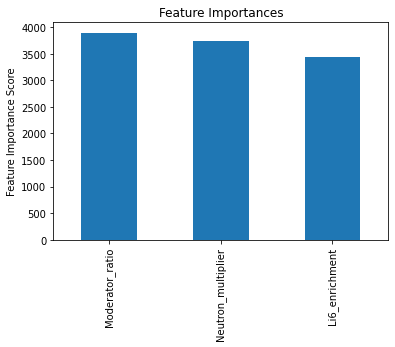

In [32]:
# Plot Importance
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [34]:
# First Tunning
param_test1 = {
 'max_depth':range(1,10,2),
 'min_child_weight':range(1,5,2)
}
gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch1.fit(df[features_columns], df['Tbr_OpenMC'])

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [35]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, -0.0012696851488972326)

In [37]:
# Second Tunning
param_test1 = {
 'max_depth':[1,1.5,2,2.5],
 'min_child_weight':[3,3.5,4,4.5]
}
gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch1.fit(df[features_columns], df['Tbr_OpenMC'])
gsearch1.best_params_, gsearch1.best_score_

/home/husninaufalz/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [-0.00214945 -0.00217667 -0.00217667 -0.00354498         nan         nan
         nan         nan -0.00127682 -0.00126892 -0.00126892 -0.00179408
         nan         nan         nan         nan]
  warnings.warn(


({'max_depth': 2, 'min_child_weight': 3.5}, -0.0012689162822898707)

In [38]:
# Build first model
model1 = xgboost.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3.5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 eval_metric= 'rmse',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

# Fit first model
features_columns = [col for col in df.columns if col not in ['Tbr_OpenMC', 'Stddev']]
model1.fit(df[features_columns], df['Tbr_OpenMC'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=3.5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

Text(0, 0.5, 'Feature Importance Score')

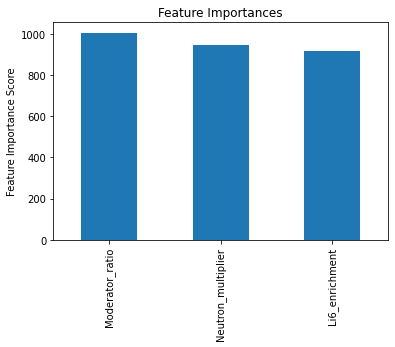

In [39]:
# Plot Importance
feat_imp = pd.Series(model1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [40]:
# Third Tunning
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = model1, param_grid = param_test3, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch1.fit(df[features_columns], df['Tbr_OpenMC'])
gsearch1.best_params_, gsearch1.best_score_

({'gamma': 0.0}, -0.0012689162822898707)

In [41]:
# Same Result

In [42]:
# Fourth Tunning
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch1 = GridSearchCV(estimator = model1, param_grid = param_test4, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch1.fit(df[features_columns], df['Tbr_OpenMC'])
gsearch1.best_params_, gsearch1.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.6}, -0.0012576752585245177)

In [ ]:
# Fifth Tunning
param_test5 = {
 'subsample':[0.65, 0.7, 0.75],
 'colsample_bytree':[0.5, 0.6, 0.7]
}
gsearch1 = GridSearchCV(estimator = model1, param_grid = param_test5, scoring='neg_root_mean_squared_error', n_jobs=4, cv=5)
gsearch1.fit(df[features_columns], df['Tbr_OpenMC'])
gsearch1.best_params_, gsearch1.best_score_

In [38]:
# Build first model
model1 = xgboost.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=3.5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 eval_metric= 'rmse',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

# Fit first model
features_columns = [col for col in df.columns if col not in ['Tbr_OpenMC', 'Stddev']]
model1.fit(df[features_columns], df['Tbr_OpenMC'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=3.5, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

Text(0, 0.5, 'Feature Importance Score')

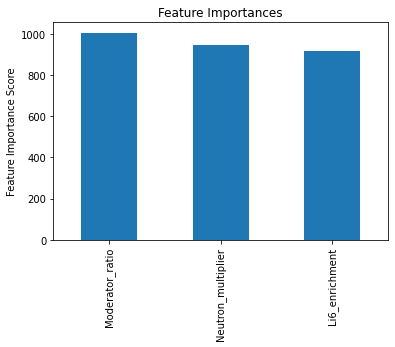

In [39]:
# Plot Importance
feat_imp = pd.Series(model1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [24]:
# Make predictions with first model for test data
features_columns = [col for col in df.columns if col not in ['Tbr', 'Stddev']]
y_pred = model.predict(df_test[features_columns])

array([0.73191637, 0.73191637, 0.73191637, ..., 0.8391198 , 0.8391198 ,
       0.8391198 ], dtype=float32)

In [31]:
# Hyperparameters Tunning
# for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.8],
   'gamma':[0,0.03,0.3],
   'min_child_weight':[1,6,10],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[1000],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]
}

xgb_model = xgboost.XGBRegressor(colsample_bytree=0.8,
                                 gamma=0,
                                 min_child_weight=1,
                                 learning_rate=0.1,
                                 max_depth=5,
                                 n_estimators=1000,
                                 reg_alpha=0.75,
                                 reg_lambda=0.45,
                                 subsample=0.8,
                                 seed=42)

gsearch1 = GridSearchCV(estimator = xgb_model,
                        param_grid = parameters_for_testing,
                        n_jobs=2,
                        verbose=10,
                        scoring='neg_root_mean_squared_error',
                        cv=5
                       )
gsearch1.fit(df[features_columns], df['Tbr'])

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.4,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.07, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None, nthread=8...
                                    subsample=0.6, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=2,
             param_grid={'colsample_bytree': [0.4, 0.8],
                         'gamma': [0, 0.03, 0.3], 'learning_rate': [0.1, 0.07

In [32]:
# See best parameters and best score
print('===================== best params =====================')
print (gsearch1.best_params_)
print('===================== best score =====================')
print (gsearch1.best_score_)

===================== best params =====================
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.6}
===================== best score =====================
-0.001086115390380058


In [33]:
# Build model based on best parameters
best_model = xgboost.XGBRegressor(gsearch1.best_params_)

/home/husninaufalz/miniconda3/lib/python3.8/site-packages/xgboost/core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


In [34]:
# Build a new model based on best parameters
features_columns = [col for col in df.columns if col not in ['Tbr', 'Stddev']]
best_model.fit(df[features_columns],df['Tbr'])

XGBoostError: [21:30:18] ../src/objective/objective.cc:26: Unknown objective function: `{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.6}`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: reg:pseudohubererror
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie

Stack trace:
  [bt] (0) /home/husninaufalz/miniconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9133f) [0x7f68be6d833f]
  [bt] (1) /home/husninaufalz/miniconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x2340ce) [0x7f68be87b0ce]
  [bt] (2) /home/husninaufalz/miniconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1c4a7c) [0x7f68be80ba7c]
  [bt] (3) /home/husninaufalz/miniconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1d225d) [0x7f68be81925d]
  [bt] (4) /home/husninaufalz/miniconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1b9829) [0x7f68be800829]
  [bt] (5) /home/husninaufalz/miniconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x50) [0x7f68be6c7ed0]
  [bt] (6) /home/husninaufalz/miniconda3/lib/python3.8/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f69601ef9dd]
  [bt] (7) /home/husninaufalz/miniconda3/lib/python3.8/lib-dynload/../../libffi.so.7(+0x6067) [0x7f69601ef067]
  [bt] (8) /home/husninaufalz/miniconda3/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0xa56) [0x7f6960209f96]



In [ ]:
# See fscore of each variables
OrderedDict(sorted(best_model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

In [ ]:
# Make predictions with best model for test data
y_pred = best_model.predict(df_test[features_columns])
df_test_new = df_test.copy()
df_test_new["Tbr_XGBoost"] = y_pred

In [ ]:
%matplotlib inline
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *


# reading a dummy dataset
x = df_test_new["Li6_enrichment"].tolist()
y = df_test_new["Moderator_ratio"].tolist()
z = df_test_new["Tbr_XGBoost"].tolist()

colo = df_test_new["Neutron_multiplier"].tolist()

# creating 3d figures
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.plasma)
color_map.set_array(colo)

# creating the heatmap
img = ax.scatter(x, y, z, marker='o', s=50, c=z, cmap=cm.plasma)
heatmap = plt.colorbar(color_map)
heatmap.set_label('Neutron Multiplier', rotation=270, labelpad=20)

# adding title and labels
ax.set_title("3D Heatmap of Simulation Result")
ax.set_xlabel('Li6 Enrichment')
ax.set_ylabel('Moderator Ratio')
ax.set_zlabel('Tritium Breeding Ratio')

# displaying plot
plt.show()
